#### Подготовка среды

In [1]:
import json
from typing import List

import numpy as np
from joblib import Parallel, delayed

from time_series import TimeSeries
from user_interface import InputParams, process_cli

In [2]:
def get_files_names(params: InputParams) -> List[str]:
    """
    Возвращает список имён файлов с данными
    """
    if params.tickets_group:
        with open('configuration.json', 'r') as file:
            configuration = json.load(file)
        return configuration['tickets_groups'][params.tickets_group]
    else:
        return params.files_names

def process_ts(file_name: str, time_series_params: dict) -> TimeSeries:
    """
    Обработка одного временного ряда
    time_series_params — словарь параметров для обработки временного ряда
    """
    ts = TimeSeries(file_name=file_name, **time_series_params)
    ts.process()
    return ts


def train_ts_model(ts: TimeSeries) -> TimeSeries:
    """
    Создание моделей временного ряда
    """
    ts.rolling_models()
    return ts

#### Начало обработки данных

In [3]:
params = InputParams(
    # data
    directory = 'data',
    files_names = None,
    tickets_group = 'NDXT_30',
    file_extension = 'csv',
    time_column = 'date',
    processed_columns = ['open', 'close'],
    target_frequency = 'H',
    frequency_method = 'mean',
    missing_method = 'rolling',
    anomaly_method = 'rolling',
    rolling_window = 2,
    z_threshold = 3.0,
    decompose_model = 'additive',
    decompose_period = 24*7*4, # дискретизация тренда по месяцам при условии наличия часовых наблюдений
    # xgboost
    n_estimators = 500,
    max_depth = 5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="mae",
    early_stopping_rounds=20,
    train_ratio=0.9,
    cv_method="expanding",
    cv_freq="M"
)

In [4]:
files_names = get_files_names(params)

time_series_params = dict(
    directory=params.directory,
    file_extension=params.file_extension,
    time_column=params.time_column,
    processed_columns=params.processed_columns,
    target_frequency=params.target_frequency,
    frequency_method=params.frequency_method,
    missing_method=params.missing_method,
    anomaly_method=params.anomaly_method,
    rolling_window=params.rolling_window,
    z_threshold=params.z_threshold,
    decompose_model=params.decompose_model,
    decompose_period=params.decompose_period,
    n_estimators=params.n_estimators,
    max_depth=params.max_depth,
    learning_rate=params.learning_rate,
    subsample=params.subsample,
    colsample_bytree=params.colsample_bytree,
    random_state=params.random_state,
    eval_metric=params.eval_metric,
    early_stopping_rounds=params.early_stopping_rounds,
    train_ratio=params.train_ratio,
    cv_method=params.cv_method,
    cv_freq=params.cv_freq
)

In [5]:
# Параллельная обработка временных рядов
time_series: List[TimeSeries] = Parallel(n_jobs=-1, backend='threading', verbose=10)(
    delayed(process_ts)(file_name, time_series_params)
    for file_name in files_names
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    6.0s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    9.3s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   10.0s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   10.6s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   11.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.3s finished


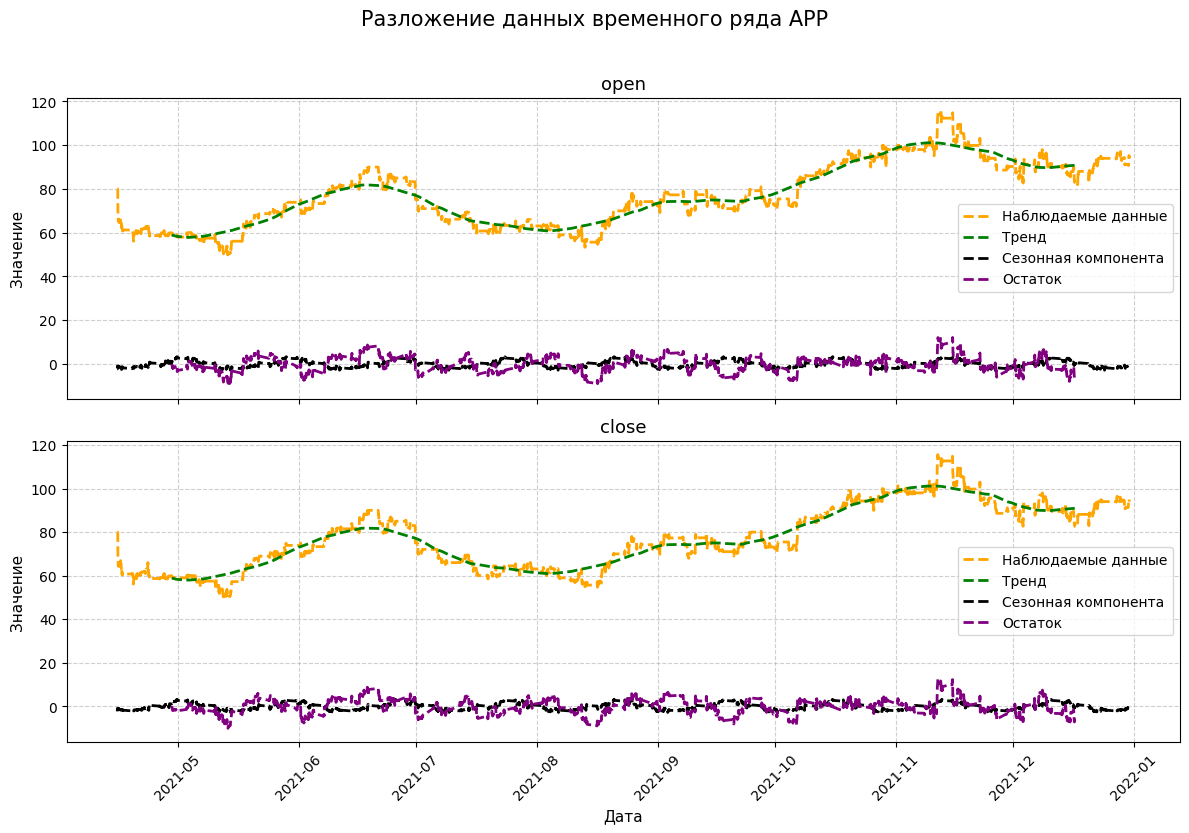

In [6]:
# После обработки визуализируем один тикет
for ts in time_series:
    if ts.file_name == 'APP':
        ts.show()

In [7]:
# Набор данных для примера
for ts in time_series:
    if ts.file_name == 'APP':
        example_ts = ts
# Выводим обработанные данные категории open одного тикета
example_ts.data_processed_columns['open'].style

#### Cоздание моделей

In [8]:
# Параллельное создание 10 моделей временных рядов
time_series_models: List[TimeSeries] = Parallel(n_jobs=-1, backend='threading', verbose=10)(
    delayed(train_ts_model)(ts=ts)
    for ts in time_series
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\wor

c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   44.5s remaining:   44.5s
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work

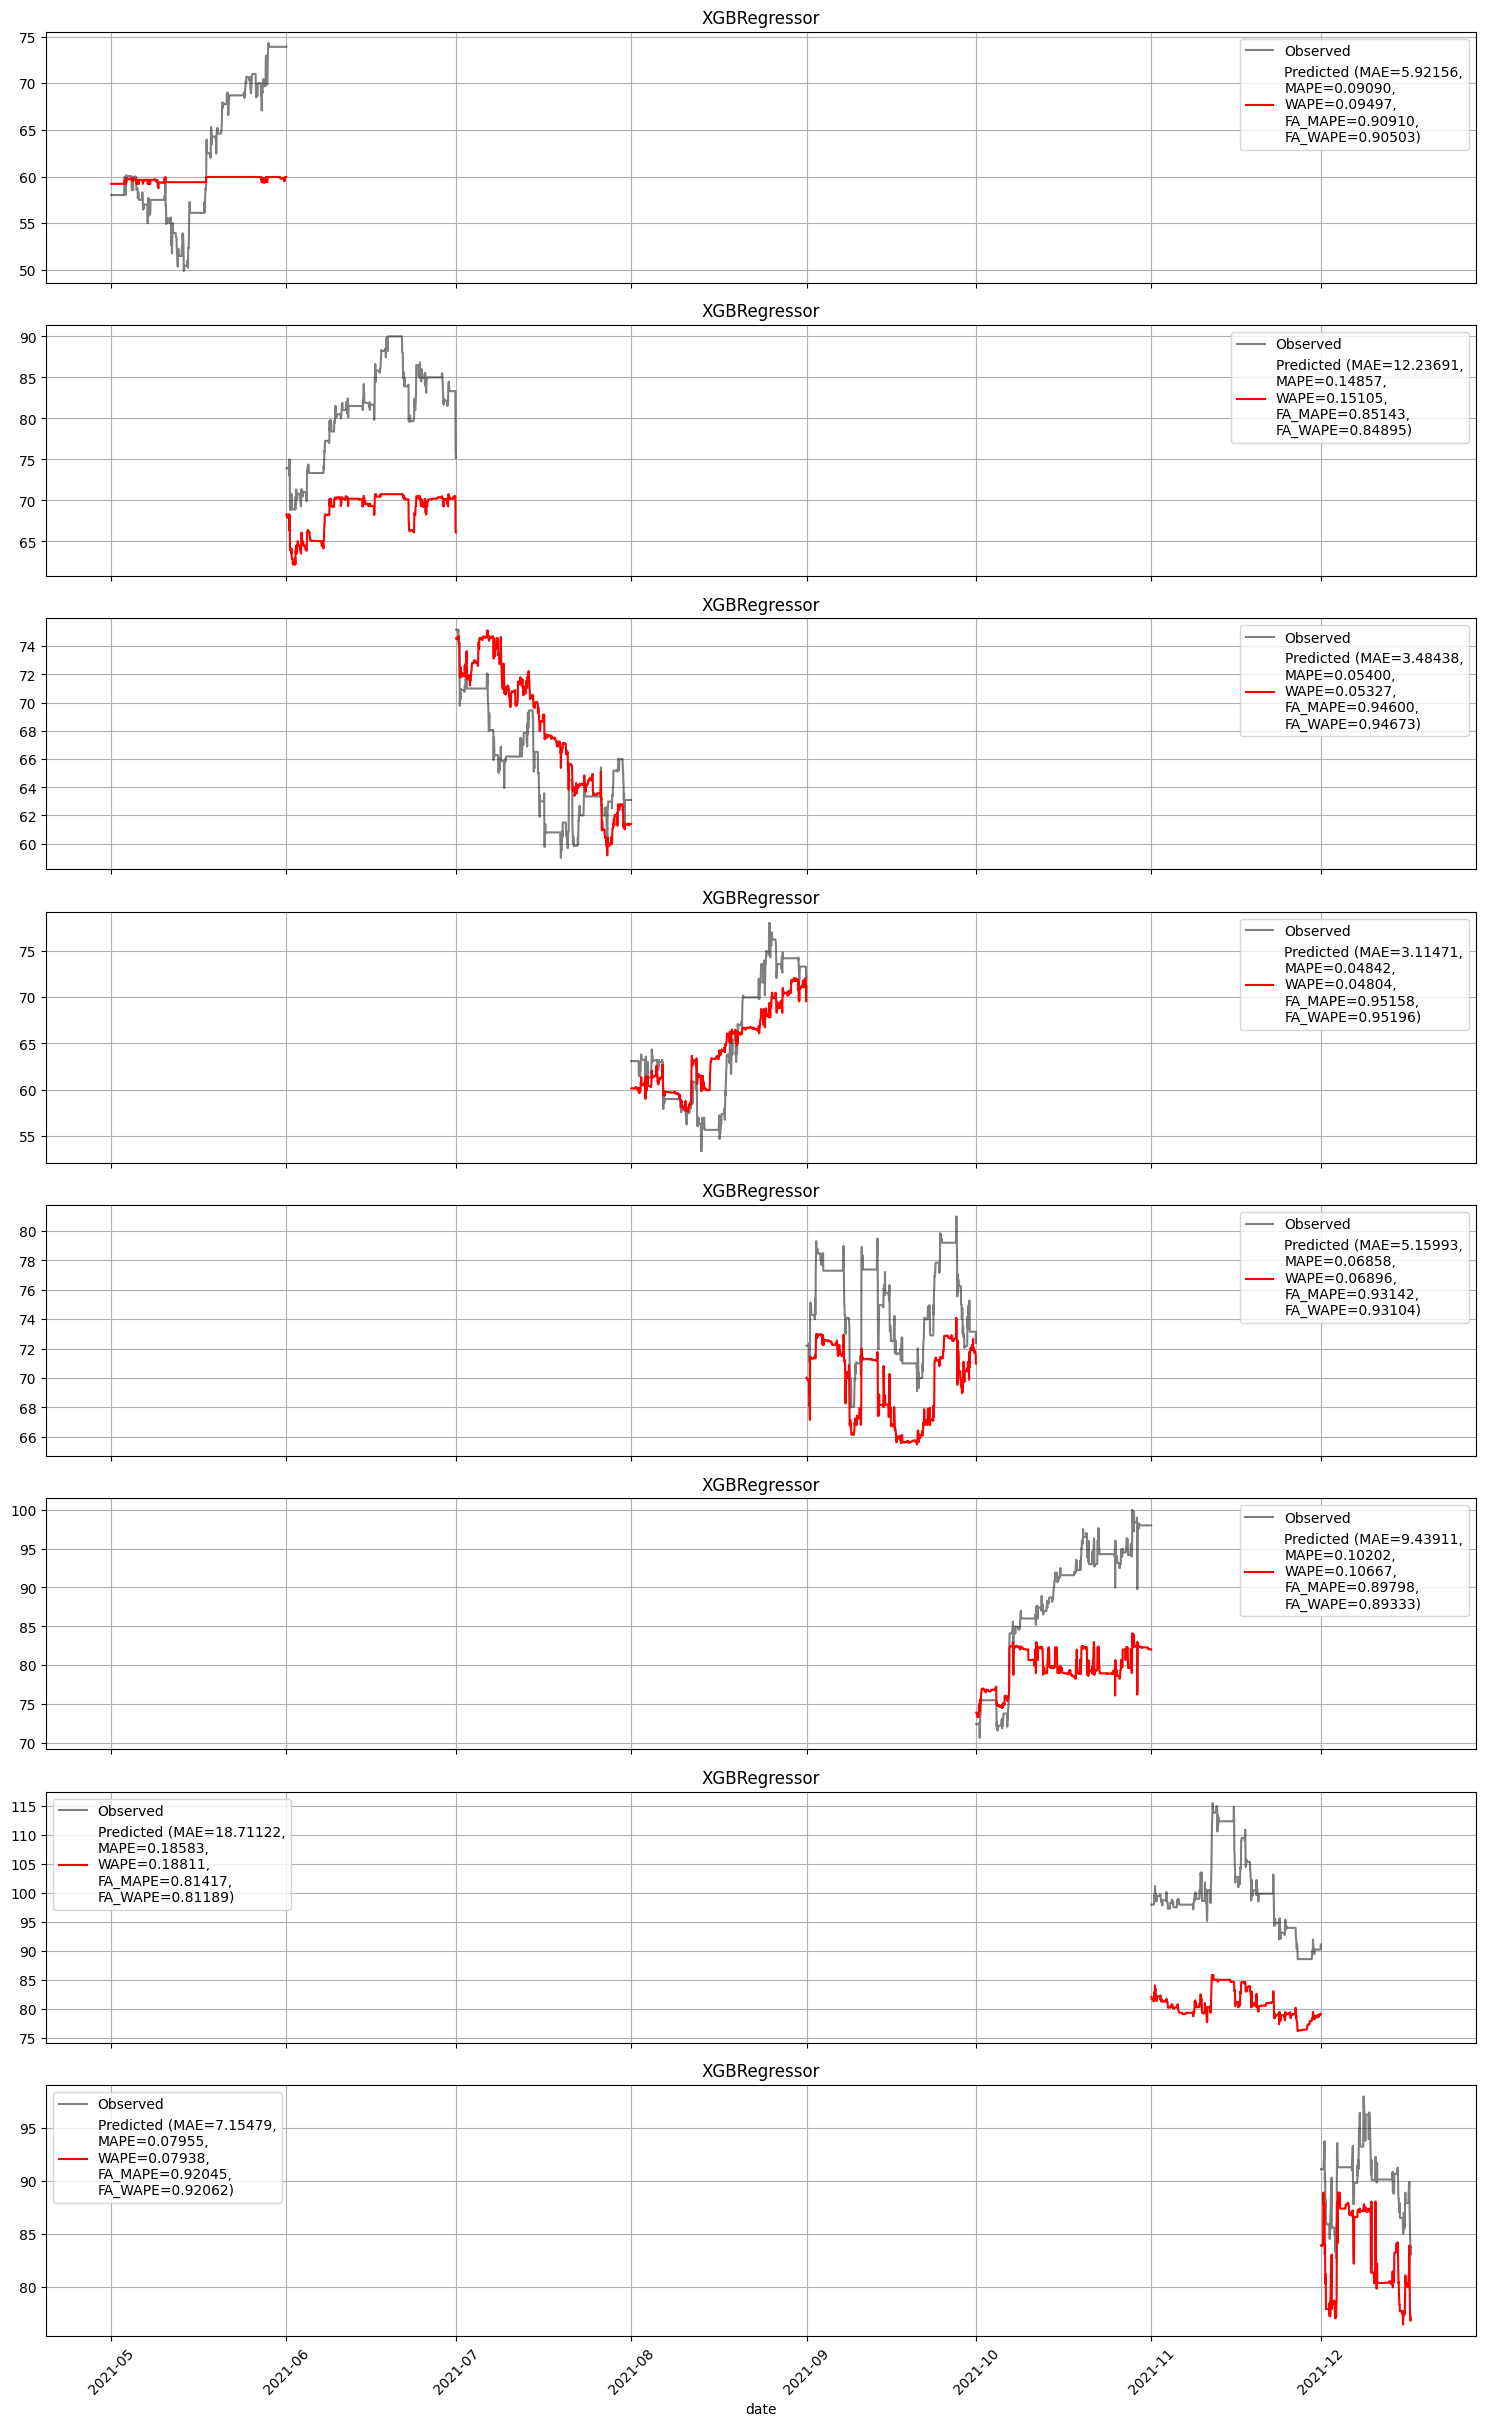

In [9]:
# Набор данных для примера
for ts in time_series_models:
    if ts.file_name == 'APP':
        example_ts = ts
# Выводим значение метрики MAE для 10 моделей
example_ts.show_metric(column_name = 'open')

In [10]:
# Получаем лучшую модель
effective_model = example_ts.get_effective_model(column_name = 'open', metric_name = 'MAE')

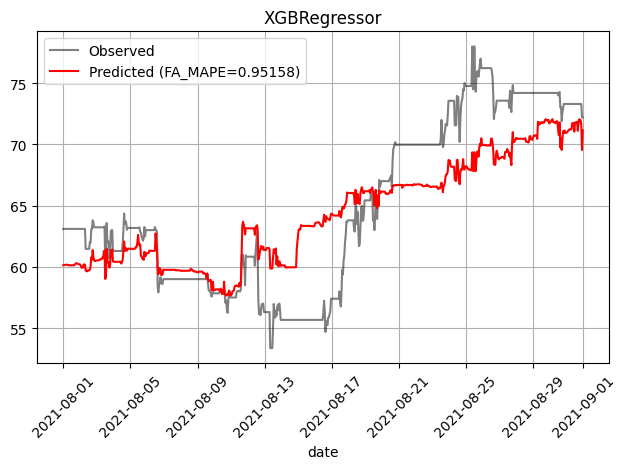

In [11]:
# Полученная модель
effective_model.show(metric_name = 'FA_MAPE')

#### Проверка моделей

In [12]:
# Глубина дерева: 2, 4, 8
effective_models = list()
for depth in [2, 4, 8]:
    for ts in time_series:
        ts.max_depth = depth
    time_series_models: List[TimeSeries] = Parallel(n_jobs=-1, backend='threading', verbose=10)(
        delayed(train_ts_model)(ts=ts)
        for ts in time_series
    )
    # Набор данных для примера
    for ts in time_series_models:
        if ts.file_name == 'AAPL':
            example_ts = ts
    # Получаем лучшую модель
    effective_model = example_ts.get_effective_model(column_name = 'open', metric_name = 'MAE')
    effective_models.append(effective_model)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\wor

c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   39.6s remaining:   39.6s
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work

c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   28.5s remaining:   49.4s
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work

c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.p

c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.3min remaining:   24.1s
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work

##### Подготовка валидационных данных

In [13]:
params__valid = InputParams(
    directory = 'data',
    files_names = None,
    tickets_group = 'NDXT_1',
    file_extension = 'csv',
    time_column = 'date',
    processed_columns = ['open', 'close'],
    target_frequency = 'H',
    frequency_method = 'mean',
    missing_method = 'rolling',
    anomaly_method = 'rolling',
    rolling_window = 2,
    z_threshold = 3.0,
    decompose_model = 'additive',
    decompose_period = 24*7*4, # дискретизация тренда по месяцам при условии наличия часовых наблюдений
    # xgboost
    n_estimators = 500,
    max_depth = 5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="mae",
    early_stopping_rounds=20,
    train_ratio=0.9,
    cv_method="expanding",
    cv_freq="M"
)

files_names__valid = get_files_names(params__valid)

time_series_params__valid = dict(
    directory=params__valid.directory,
    file_extension=params__valid.file_extension,
    time_column=params__valid.time_column,
    processed_columns=params__valid.processed_columns,
    target_frequency=params__valid.target_frequency,
    frequency_method=params__valid.frequency_method,
    missing_method=params__valid.missing_method,
    anomaly_method=params__valid.anomaly_method,
    rolling_window=params__valid.rolling_window,
    z_threshold=params__valid.z_threshold,
    decompose_model=params__valid.decompose_model,
    decompose_period=params__valid.decompose_period,
    n_estimators=params__valid.n_estimators,
    max_depth=params__valid.max_depth,
    learning_rate=params__valid.learning_rate,
    subsample=params__valid.subsample,
    colsample_bytree=params__valid.colsample_bytree,
    random_state=params__valid.random_state,
    eval_metric=params__valid.eval_metric,
    early_stopping_rounds=params__valid.early_stopping_rounds,
    train_ratio=params__valid.train_ratio,
    cv_method=params__valid.cv_method,
    cv_freq=params__valid.cv_freq
)

In [14]:
time_series__valid: List[TimeSeries] = Parallel(n_jobs=-1, backend='threading', verbose=10)(
    delayed(process_ts)(file_name, time_series_params__valid)
    for file_name in files_names__valid
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s


In [15]:
time_series__valid: List[TimeSeries] = Parallel(n_jobs=-1, backend='threading', verbose=10)(
    delayed(train_ts_model)(ts=ts)
    for ts in time_series__valid
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
c:\users\unico\desktop\work\repositories\ml_education\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s


In [16]:
valid_ts = time_series__valid[0]

In [17]:
valid_x = valid_ts.models_metadata['open'][0].x

In [18]:
valid_y = valid_ts.models_metadata['open'][0].y

##### Валидация

max_depth_tree = 2


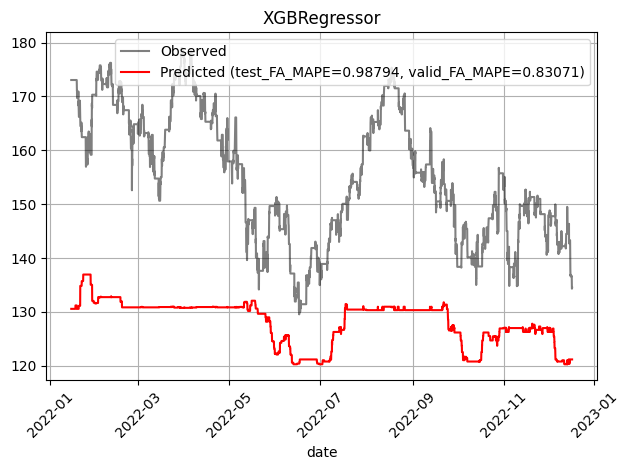

max_depth_tree = 4


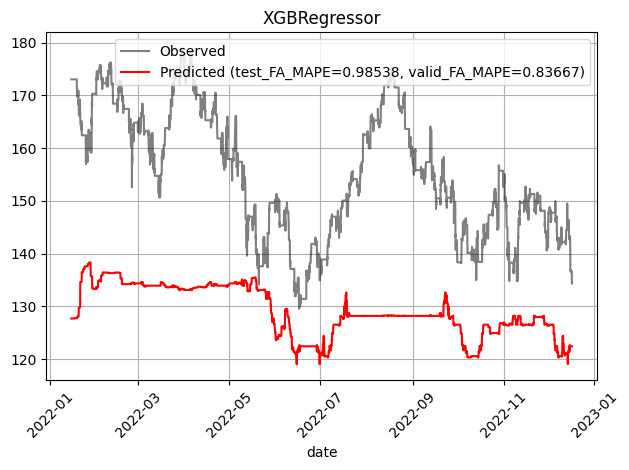

max_depth_tree = 8


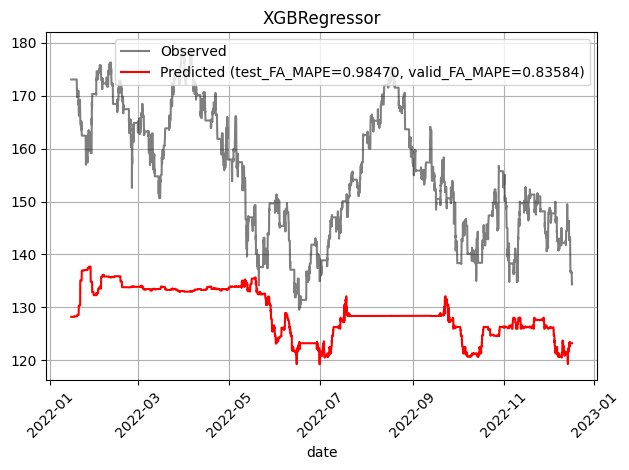

In [19]:
for effective_model in effective_models:
    print(f'max_depth_tree = {effective_model.model.max_depth}')
    effective_model.predict(x_data=valid_x, y_data=valid_y, metric_name='FA_MAPE')